In [26]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)

In [27]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

In [28]:
library(data.table)
library(hts)  

In [29]:
df_eu  <-  read.csv(file="hts_us_ind_filled.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2005   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [30]:
df_eu$DEAGR  <-  NULL
df_eu$DEMIN  <-  NULL

In [31]:
var_h  <- 8
var_window  <-  28 - 1
var_topup  <-  2
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [32]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,0,0)
# var_sarpdq   <-  c(2,0,0)
var_char  <-  c(2,3)

In [33]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=19, end=46)
# gts_test  <- window(y, start=47, end=54)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [34]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,   include.mean = TRUE, xreg = regressors, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,  include.mean = TRUE, xreg = regressors, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h, drift=TRUE)$mean}
    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 28 29 36
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1048 
Total number of series: 1099 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15854.11 15874.65 15869.77 15834.87 15793.48 15751.44 15716.28 15693.46
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1048 
Total number of series: 1099 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15927.74 15976.31 15983.43 15994.99 16128.30 16136.38 16254.91 16372.60
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1048 
Total number of series: 1099 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16011.61 16048.27 16110.78 16197.61 16304.48 16423.72 16547.49 16669.65
Hierarchical Time Series

In [35]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [36]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [37]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [38]:
df_acc

ME,RMSE,MAPE,Iteration
298.3255,365.0262,1.8417475,1
120.1315,130.8103,0.7303764,5
-309.9452,328.7679,1.8330782,9
-200.2146,251.9047,1.1563454,13
-147.9632,172.3454,0.8399890,17
-198.0465,205.7366,1.1164695,19


In [39]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 17237.26 17336.36 17457.06 17596.93 17728.33 17853.92 17972.47 18085.14

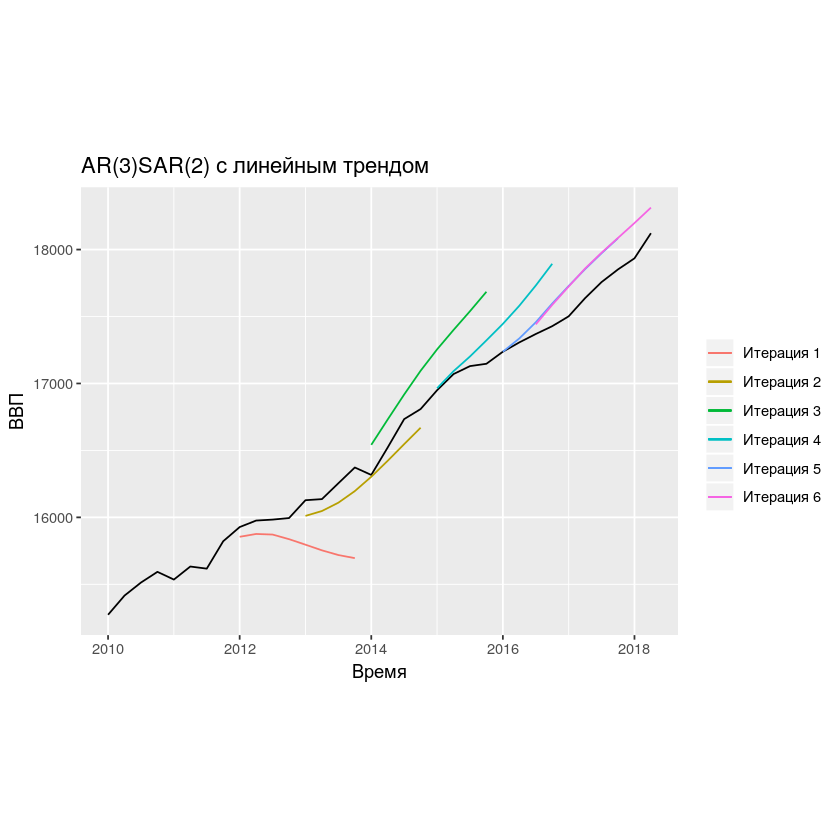

In [40]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [41]:
df_acc[-3,]

,ME,RMSE,MAPE,Iteration
1,298.3255,365.0262,1.8417475,1
2,120.1315,130.8103,0.7303764,5
4,-200.2146,251.9047,1.1563454,13
5,-147.9632,172.3454,0.8399890,17
6,-198.0465,205.7366,1.1164695,19


In [42]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-72.952089 242.431872   1.253001  10.666667

In [43]:
df_mean_acc <- readRDS("df_mean_acc.rds")
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.432632797146,9616.41574753439
2 level (state),62.0365866565657,241.696134642821,11173.0672424215
2 level (type),61.8934203477981,242.432733556294,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [44]:
df_mean_acc[2,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9616.41574753439
2 level (state),62.0365866565657,241.696134642821,11173.0672424215
2 level (type),61.8934203477981,242.432733556294,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [45]:
df_acc

ME,RMSE,MAPE,Iteration
298.3255,365.0262,1.8417475,1
120.1315,130.8103,0.7303764,5
-309.9452,328.7679,1.8330782,9
-200.2146,251.9047,1.1563454,13
-147.9632,172.3454,0.8399890,17
-198.0465,205.7366,1.1164695,19


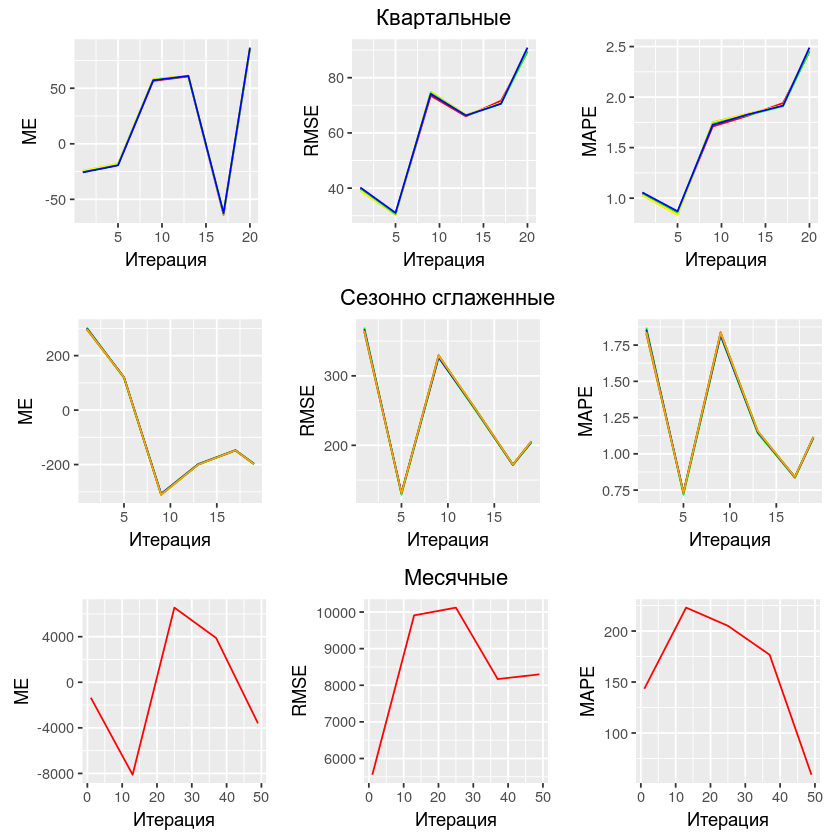

In [46]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [51]:
df_eu  <-  read.csv(file="hts_us_ind_filled_state.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [52]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [53]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [54]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,  include.mean = TRUE, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,  include.mean = TRUE, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h, drift=TRUE)$mean}
    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15854.15 15874.72 15869.94 15835.08 15793.72 15751.67 15716.48 15693.63
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15927.74 15976.31 15983.43 15994.99 16128.30 16136.38 16254.91 16372.60
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16011.59 16048.21 16110.72 16197.57 16304.46 16423.77 16547.60 16669.83
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 33 
End = 40 
Frequency = 1 
[1] 16128.30 16136.38 16254.91 16372.60 16316.98 16522.48 16733.98 16809.04
[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16541.52 16731.00 16917.16 17094.13 17253.60 17398.75 17538.97 17684.67
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 37 
End = 44 
Frequency = 1 
[1] 16316.98 16522.48 16733.98 16809.04 16949.40 17070.24 17129.69 17147.05
|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16964.53 17092.32 17202.13 17322.93 17446.53 17582.09 17733.22 17895.58
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 41 
End = 48 
Frequency = 1 
[1] 16949.40 17070.24 17129.69 17147.05 17237.31 17306.78 17369.38 17427.95
|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17237.92 17337.46 17458.14 17597.89 17729.05 17854.35 17972.90 18085.71
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 45 
End = 52 
Frequency = 1 
[1] 17237.31 17306.78 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87
[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17440.95 17587.14 17724.17 17858.93 17977.01 18087.12 18198.02 18313.18
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 47 
End = 54 
Frequency = 1 
[1] 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87 17934.57 18122.00


In [55]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [56]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [57]:
df_acc

ME,RMSE,MAPE,Iteration
298.1609,364.8713,1.8407268,1
120.1161,130.7872,0.7302894,5
-310.1171,328.9618,1.8340890,9
-200.1925,251.8752,1.1562181,13
-147.9773,172.3588,0.8400696,17
-198.0530,205.7420,1.1165067,19


In [58]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 17237.26 17336.36 17457.06 17596.93 17728.33 17853.92 17972.47 18085.14

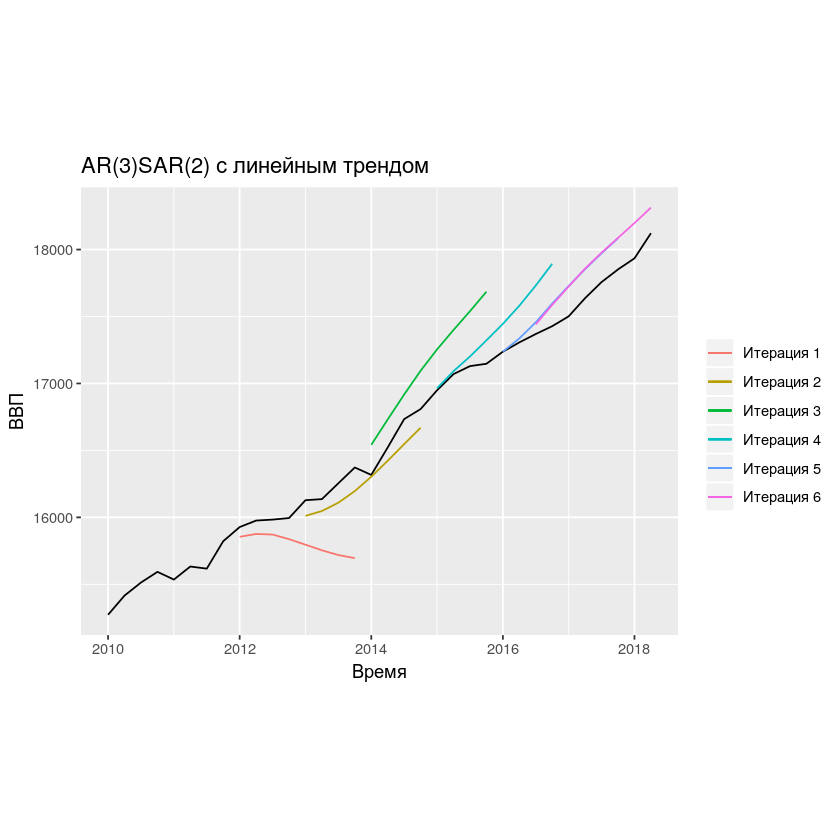

In [59]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [61]:
colMeans(df_acc)
df_mean_acc

ME       RMSE       MAPE  Iteration 
-73.010509 242.432734   1.252983  10.666667

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9616.41574753439
2 level (state),62.0365866565657,241.696134642821,11173.0672424215
2 level (type),61.8934203477981,242.432733556294,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [ ]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [62]:
df_mean_acc[3,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9616.41574753439
2 level (state),62.0365866565657,242.432733556294,11173.0672424215
2 level (type),61.8934203477981,242.432733556294,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


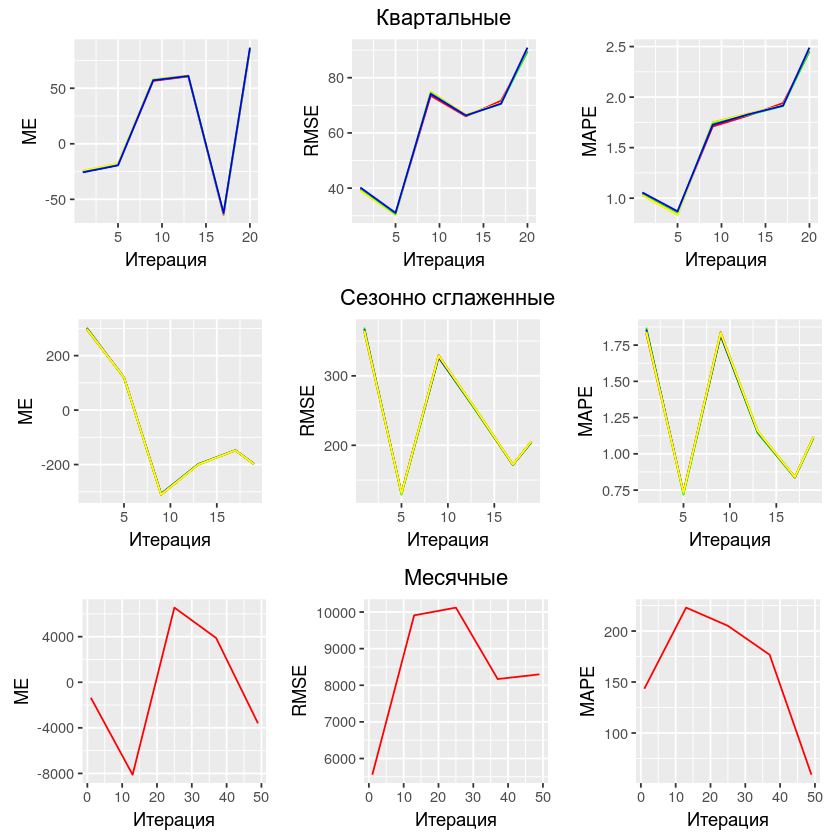

In [63]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [74]:
df_eu  <-  read.csv(file="hts_us_ind_filled_type.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [75]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [76]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [77]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,  include.mean = TRUE, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,  include.mean = TRUE, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h, drift=TRUE)$mean}
    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15853.97 15871.96 15864.95 15828.85 15786.57 15745.30 15710.77 15688.77
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15927.74 15976.31 15983.43 15994.99 16128.30 16136.38 16254.91 16372.60
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16012.57 16049.15 16112.34 16199.80 16306.99 16426.12 16550.26 16672.59
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 33 
End = 40 
Frequency = 1 
[1] 16128.30 16136.38 16254.91 16372.60 16316.98 16522.48 16733.98 16809.04
[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16539.01 16726.85 16912.34 17088.61 17249.17 17396.32 17537.72 17683.77
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 37 
End = 44 
Frequency = 1 
[1] 16316.98 16522.48 16733.98 16809.04 16949.40 17070.24 17129.69 17147.05
|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16963.19 17089.83 17199.07 17319.42 17443.81 17580.07 17731.04 17892.85
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 41 
End = 48 
Frequency = 1 
[1] 16949.40 17070.24 17129.69 17147.05 17237.31 17306.78 17369.38 17427.95
|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17237.18 17335.95 17457.10 17597.02 17728.44 17854.05 17972.38 18084.86
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 45 
End = 52 
Frequency = 1 
[1] 17237.31 17306.78 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87
[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17440.79 17585.81 17724.00 17857.23 17974.71 18084.42 18195.49 18310.79
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 47 
End = 54 
Frequency = 1 
[1] 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87 17934.57 18122.00


In [78]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [79]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [80]:
df_acc

ME,RMSE,MAPE,Iteration
302.9422,369.3600,1.8703770,1
118.1058,128.9118,0.7180889,5
-306.8670,326.3020,1.8147127,9
-197.6844,249.8392,1.1416456,13
-147.1743,171.7807,0.8356502,17
-196.3960,203.9830,1.1072069,19


In [81]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 17237.26 17336.36 17457.06 17596.93 17728.33 17853.92 17972.47 18085.14

In [82]:
gdp_agg

         Qtr1     Qtr2     Qtr3     Qtr4
2005 14811.63 14902.34 15023.37 15102.28
2006 15315.30 15359.04 15362.28 15464.91
2007 15477.09 15549.71 15618.09 15731.69
2008 15625.55 15697.70 15582.14 15216.20
2009 15077.89 15057.17 15107.87 15246.07
2010 15272.96 15416.13 15513.43 15593.29
2011 15535.66 15633.07 15617.25 15821.95
2012 15927.74 15976.31 15983.43 15994.99
2013 16128.30 16136.38 16254.91 16372.60
2014 16316.98 16522.48 16733.98 16809.04
2015 16949.40 17070.24 17129.69 17147.05
2016 17237.31 17306.78 17369.38 17427.95
2017 17501.51 17637.46 17757.34 17851.87
2018 17934.57 18122.00                  

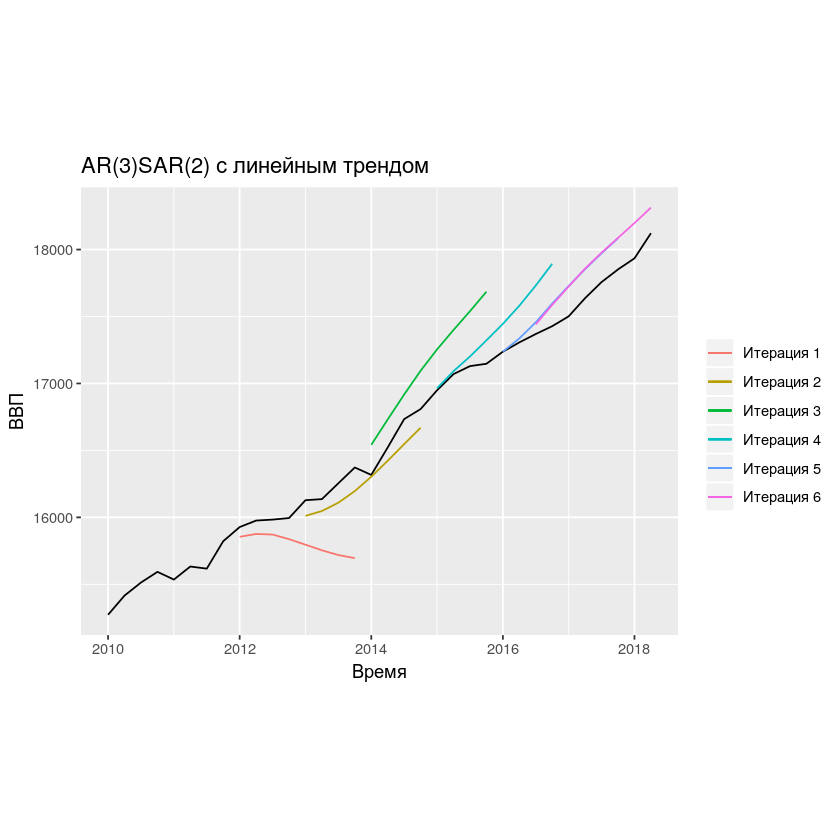

In [83]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [85]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-71.178930 241.696135   1.247947  10.666667

In [86]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [87]:
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9616.41574753439
2 level (state),62.0365866565657,242.432733556294,11173.0672424215
2 level (type),61.8934203477981,242.432733556294,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [88]:
df_mean_acc[4,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9616.41574753439
2 level (state),62.0365866565657,242.432733556294,11173.0672424215
2 level (type),61.8934203477981,241.696134642821,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


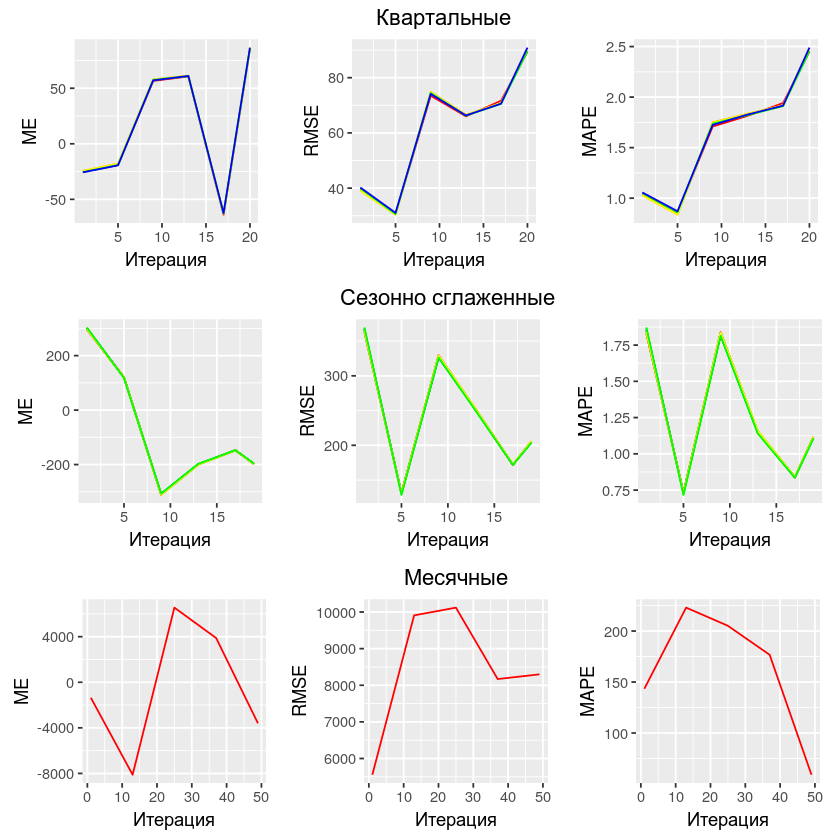

In [89]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [90]:
df_eu  <-  read.csv(file="hts_us_ind_filled_clust.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [91]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [92]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [93]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,  include.mean = TRUE, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,  include.mean = TRUE, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h, drift=TRUE)$mean}
    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15853.21 15872.56 15867.05 15831.85 15790.23 15748.80 15714.01 15691.58
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15927.74 15976.31 15983.43 15994.99 16128.30 16136.38 16254.91 16372.60
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16011.08 16047.80 16110.59 16197.45 16304.50 16423.62 16547.13 16669.09
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 33 
End = 40 
Frequency = 1 
[1] 16128.30 16136.38 16254.91 16372.60 16316.98 16522.48 16733.98 16809.04
[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16540.71 16729.33 16913.88 17090.53 17250.03 17395.66 17536.71 17682.75
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 37 
End = 44 
Frequency = 1 
[1] 16316.98 16522.48 16733.98 16809.04 16949.40 17070.24 17129.69 17147.05
|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16963.38 17090.49 17200.18 17321.90 17446.30 17581.89 17732.78 17894.13
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 41 
End = 48 
Frequency = 1 
[1] 16949.40 17070.24 17129.69 17147.05 17237.31 17306.78 17369.38 17427.95
|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17238.04 17337.58 17458.50 17597.85 17728.71 17853.94 17972.42 18085.32
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 45 
End = 52 
Frequency = 1 
[1] 17237.31 17306.78 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87
[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17441.89 17587.23 17724.00 17858.03 17975.51 18085.72 18196.80 18312.18
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 18 
Total number of series: 19 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 47 
End = 54 
Frequency = 1 
[1] 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87 17934.57 18122.00


In [94]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [95]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [96]:
df_acc

ME,RMSE,MAPE,Iteration
300.6734,366.9747,1.8563315,1
120.4257,131.1106,0.7321682,5
-307.5933,326.6039,1.8191403,9
-199.1560,251.2185,1.1501798,13
-147.8452,172.1183,0.8393315,17
-197.4094,204.9380,1.1129200,19


In [97]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 17237.26 17336.36 17457.06 17596.93 17728.33 17853.92 17972.47 18085.14

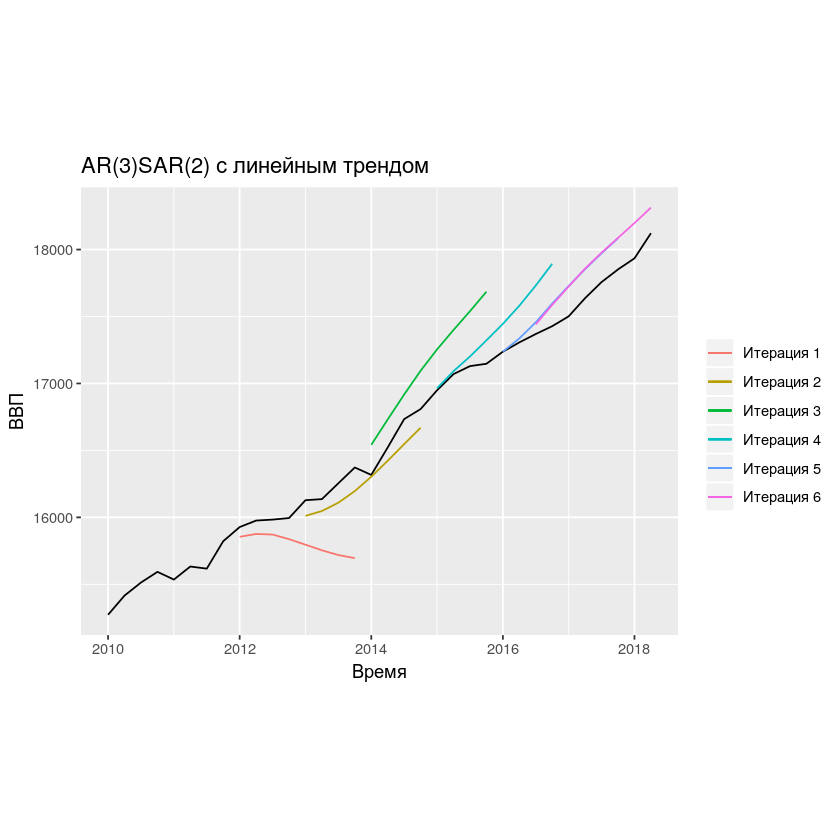

In [98]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [99]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-71.817485 242.160671   1.251679  10.666667

In [100]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [101]:
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9616.41574753439
2 level (state),62.0365866565657,242.432733556294,11173.0672424215
2 level (type),61.8934203477981,241.696134642821,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [102]:
df_mean_acc[5,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9616.41574753439
2 level (state),62.0365866565657,242.432733556294,11173.0672424215
2 level (type),61.8934203477981,241.696134642821,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


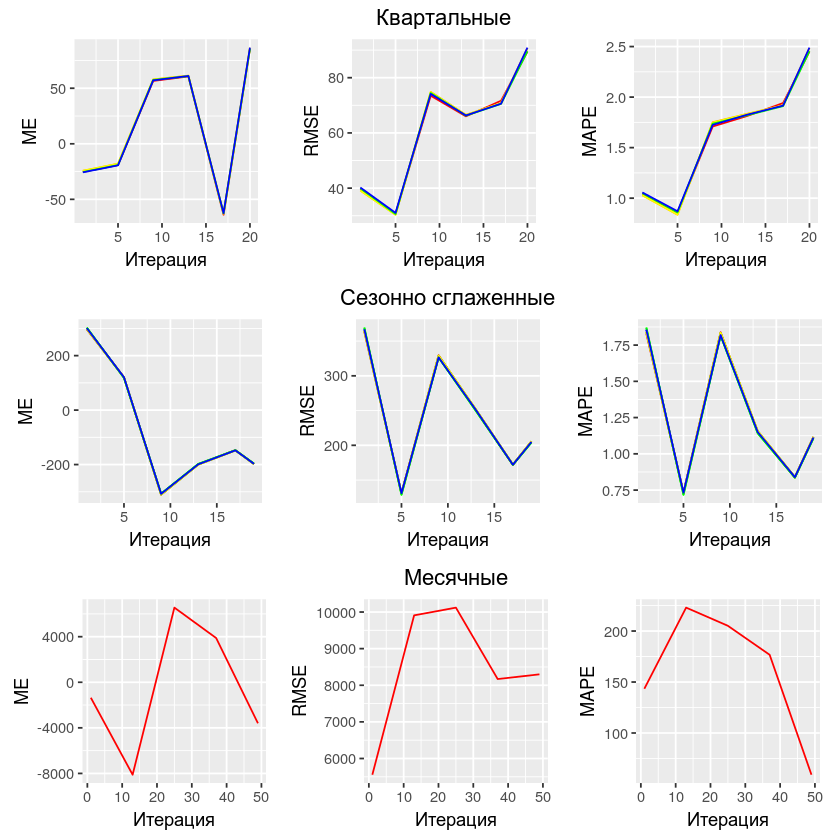

In [103]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [104]:
saveRDS(df_mean_acc, "df_mean_acc.rds")
saveRDS(plots_test_all, "plots_test_not_all.rds")